# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [2]:
%pip install --user labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations split-folders imutils scikit-learn keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Harry Parker\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import os
import cv2

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import Tensorflow and Dependences

In [4]:
import json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

### 2.2 Limit GPU Memory Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [7]:
images = tf.data.Dataset.list_files('data\\img\\img\\*.jpg')

train_images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg')
test_images = tf.data.Dataset.list_files('data\\test\\images\\*.jpg')
val_images = tf.data.Dataset.list_files('data\\val\\images\\*.jpg')

train_images.as_numpy_iterator().next()
test_images.as_numpy_iterator().next()
val_images.as_numpy_iterator().next()

In [8]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image)

In [10]:
images.as_numpy_iterator().next()

array([[[ 58,  58,  58],
        [ 74,  74,  74],
        [ 86,  86,  86],
        ...,
        [116, 116, 116],
        [100, 100, 100],
        [ 80,  80,  80]],

       [[ 85,  85,  85],
        [103, 103, 103],
        [118, 118, 118],
        ...,
        [161, 161, 161],
        [137, 137, 137],
        [112, 112, 112]],

       [[ 98,  98,  98],
        [118, 118, 118],
        [137, 137, 137],
        ...,
        [189, 189, 189],
        [156, 156, 156],
        [126, 126, 126]],

       ...,

       [[ 20,  20,  20],
        [ 24,  24,  24],
        [ 29,  29,  29],
        ...,
        [ 55,  55,  55],
        [ 47,  47,  47],
        [ 42,  42,  42]],

       [[  7,   7,   7],
        [ 10,  10,  10],
        [ 16,  16,  16],
        ...,
        [ 38,  38,  38],
        [ 31,  31,  31],
        [ 27,  27,  27]],

       [[  6,   6,   6],
        [  9,   9,   9],
        [ 15,  15,  15],
        ...,
        [ 31,  31,  31],
        [ 25,  25,  25],
        [ 22,  22,  22]]

In [11]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

train_images = train_images.map(load_image)
test_images = test_images.map(load_image)
val_images = val_images.map(load_image)

train_images.as_numpy_iterator().next()
test_images.as_numpy_iterator().next()
val_images.as_numpy_iterator().next()

type(train_images)
type(test_images)
type(val_images)

### 2.4 View Raw Images with Matplotlib

In [12]:
image_generator = images.batch(4).as_numpy_iterator()

In [13]:
plot_images = next(image_generator)

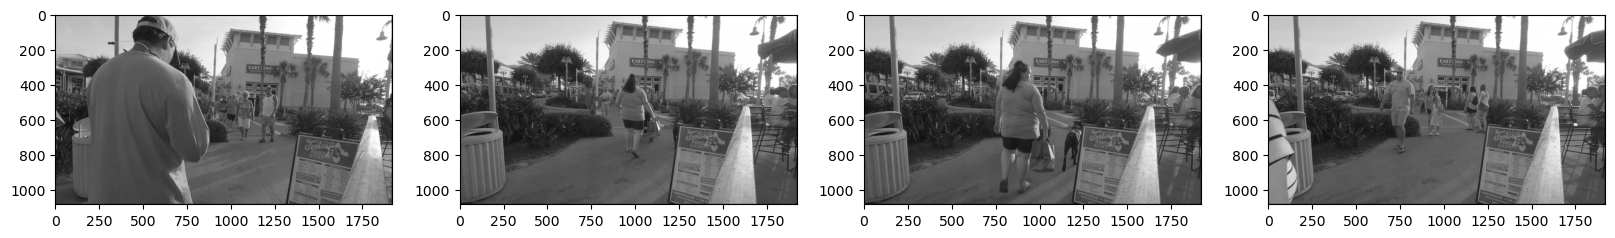

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

train_image_generator = train_images.batch(4).as_numpy_iterator()
test_image_generator = test_images.batch(4).as_numpy_iterator()
val_image_generator = val_images.batch(4).as_numpy_iterator()

plot_train_images = train_image_generator.next()
plot_test_images = test_image_generator.next()
plot_val_images = val_image_generator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_train_images):
    ax[idx].imshow(image) 
plt.show()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_test_images):
    ax[idx].imshow(image) 
plt.show()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_val_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unargumented Data

### 3.1 Split data into training and testing and valid data

In [ ]:
import splitfolders
splitfolders.ratio('./data/img', output="./data/ttvimg", seed=1337, ratio=(.8, 0.1,0.1))

### 3.2 Move the Matching Labels

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Setup Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [15]:
import albumentations as alb

In [16]:
augmentor = alb.Compose([alb.RandomCrop(width=1280, height=720)], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [17]:
testImage = cv2.imread(os.path.join('data','train','images','1.jpg'))

In [18]:
with open(os.path.join('data', 'train', 'labels', '1.json'), 'r') as f:
    label = json.load(f)

In [19]:
label['shapes'][1]['points']

[[1439.7413793103449, 350.3448275862069],
 [1558.7068965517242, 486.55172413793105]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [20]:
coords = [0,0,0,0]
coords[0] = label['shapes'][1]['points'][0][0]
coords[1] = label['shapes'][1]['points'][0][1]
coords[2] = label['shapes'][1]['points'][1][0]
coords[3] = label['shapes'][1]['points'][1][1]

In [21]:
coords

[1439.7413793103449, 350.3448275862069, 1558.7068965517242, 486.55172413793105]

In [22]:
coords = list(np.divide(coords, [1920,1080,1920,1080]))

In [23]:
coords

[0.749865301724138,
 0.32439335887611753,
 0.8118265086206897,
 0.4505108556832695]

### 4.4 Apply Augmentations and View Results

In [24]:
augmented = augmentor(image=testImage, bboxes=[coords], class_labels=['face'])

In [25]:
augmented['bboxes'][0][2:]

(0.9450835129310345, 0.28687739463601536)

In [26]:
augmented['bboxes']

[(0.8521417025862069,
  0.09770114942528739,
  0.9450835129310345,
  0.28687739463601536)]

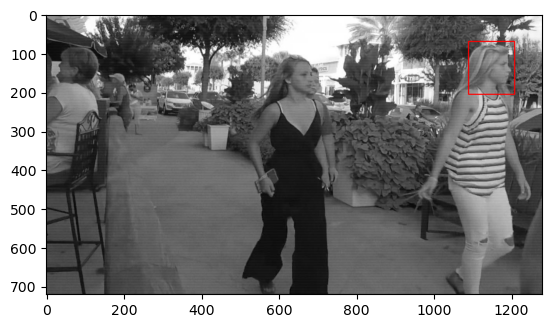

In [27]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [1280, 720]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1280, 720]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [ ]:
for partition in ['train']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('augmented-data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('augmented-data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Expected x_min for bbox [-0.0002424568965517478, 0.000574712643678489, 0.12127334770114939, 0.26851851851851855, 'face'] to be in the range [0.0, 1.0], got -0.0002424568965517478.
Expected x_min for bbox [-0.0002424568965517478, 0.000574712643678489, 0.16123383620689652, 0.28927203065134105, 'face'] to be in the range [0.0, 1.0], got -0.0002424568965517478.
Expected x_min for bbox [-0.0002424568965517478, 0.000574712643678489, 0.18817349137931033, 0.3164112388250319, 'face'] to be in the range [0.0, 1.0], got -0.0002424568965517478.
Expected x_min for bbox [-0.0002424568965517478, 0.000574712643678489, 0.2092762212643678, 0.3267879948914432, 'face'] to be in the range [0.0, 1.0], got -0.0002424568965517478.
x_max is less than or equal to x_min for bbox [0.20568426724137928, 0.08971902937420177, 0.07412895114942525, 0.2733077905491698, 'face'].
x_max is less than or equal to x_min for bbox [0.9748114224137933, 0.37707535121328223, 0.9227280890804599, 0.44013409961685823, 'face'].
x_max 

IndexError: list index out of range

### 5.2 Load Augmented Images to Tensorflow Dataset

In [28]:
train_images = tf.data.Dataset.list_files('augmented-data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (240,240)))
train_images = train_images.map(lambda x: x/255)

In [29]:
test_images = tf.data.Dataset.list_files('augmented-data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (240,240)))
test_images = test_images.map(lambda x: x/255)

In [30]:
val_images = tf.data.Dataset.list_files('augmented-data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (240,240)))
val_images = val_images.map(lambda x: x/255)

In [31]:
train_images.as_numpy_iterator().next()

array([[[0.54313725, 0.54313725, 0.54313725],
        [0.15294118, 0.15294118, 0.15294118],
        [0.16078432, 0.16078432, 0.16078432],
        ...,
        [0.28627452, 0.28627452, 0.28627452],
        [0.28235295, 0.28235295, 0.28235295],
        [0.2888892 , 0.2888892 , 0.2888892 ]],

       [[0.3248366 , 0.3248366 , 0.3248366 ],
        [0.1392157 , 0.1392157 , 0.1392157 ],
        [0.16535947, 0.16535947, 0.16535947],
        ...,
        [0.32941177, 0.32941177, 0.32941177],
        [0.3       , 0.3       , 0.3       ],
        [0.29738578, 0.29738578, 0.29738578]],

       [[0.25686276, 0.25686276, 0.25686276],
        [0.2       , 0.2       , 0.2       ],
        [0.16666667, 0.16666667, 0.16666667],
        ...,
        [0.36405197, 0.36405197, 0.36405197],
        [0.33137256, 0.33137256, 0.33137256],
        [0.33398676, 0.33398676, 0.33398676]],

       ...,

       [[0.28562093, 0.28562093, 0.28562093],
        [0.29215688, 0.29215688, 0.29215688],
        [0.28169936, 0

# 5. Prepare Labels

### 5.1 Build Label Loading Function

In [32]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 5.2 Load Labels to Tensorflow Dataset

In [33]:
train_labels = tf.data.Dataset.list_files('augmented-data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [34]:
test_labels = tf.data.Dataset.list_files('augmented-data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [35]:
val_labels = tf.data.Dataset.list_files('augmented-data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [36]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 6. Combine Labels and Image Samples

### 6.1 Check Partition Length

In [37]:
len(train_images), len(test_images), len(val_images), len(train_labels), len(test_labels), len(val_labels)

(11640, 4380, 4560, 11640, 4380, 4560)

### 6.2 Final Datasets (Images/Labels)

In [38]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [39]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [40]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()

### 6.3 View Images and Annotations

In [43]:
data_samples = train.as_numpy_iterator()

In [44]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


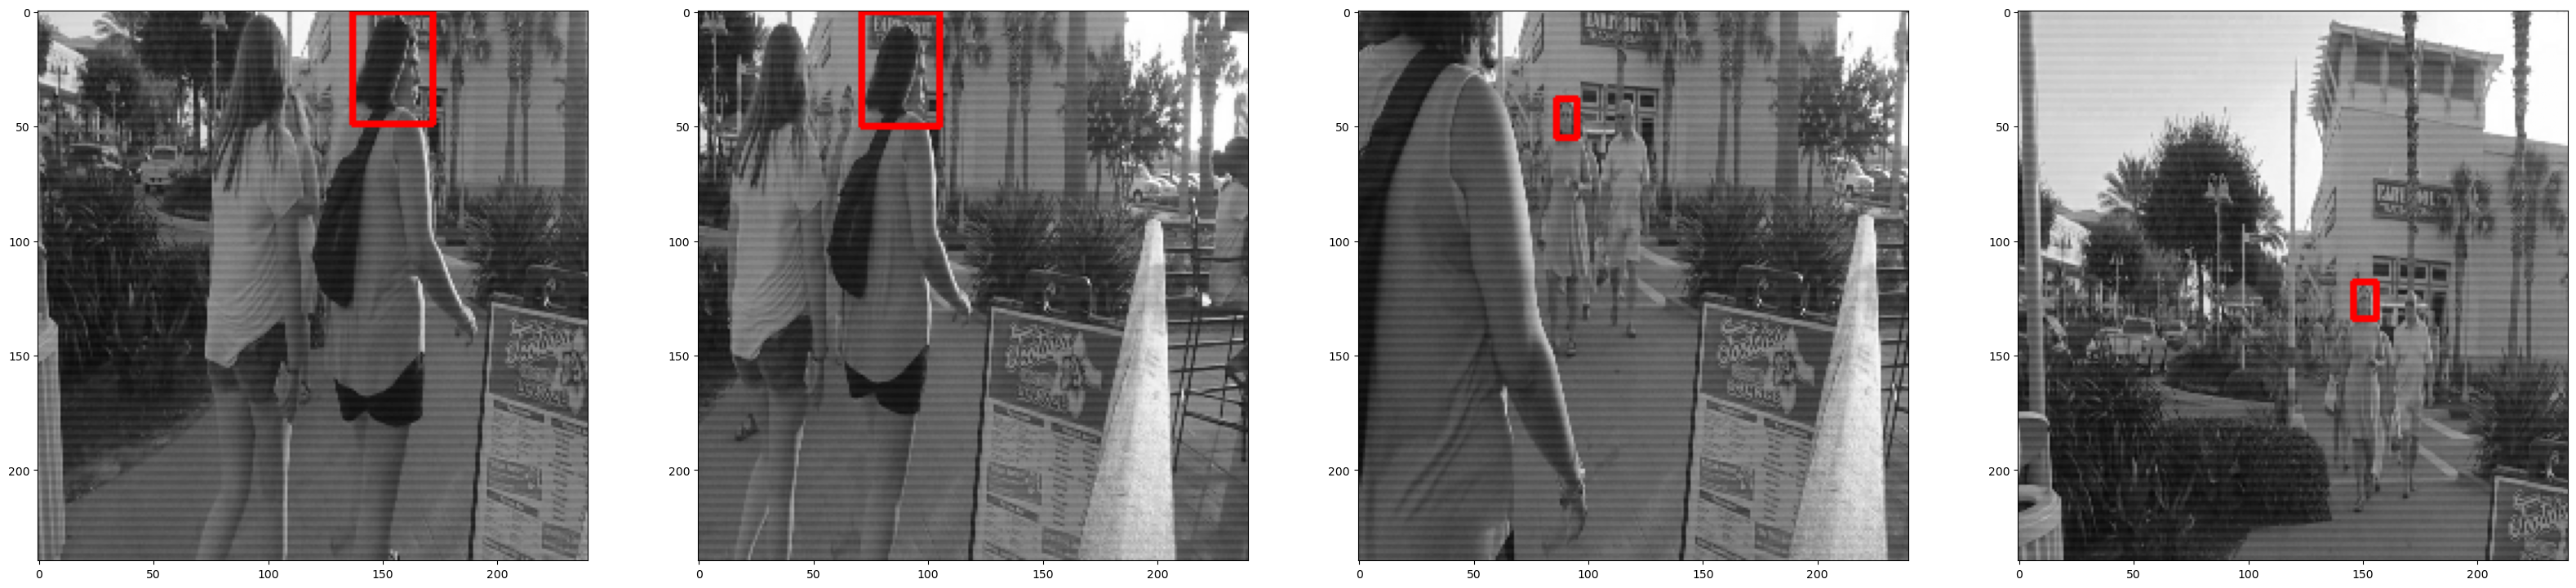

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(40,40))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [240,240]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [240,240]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 7 Build Deep Learning Model using the Functional API

### 8.1 Import Layers and Base Network

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 7.2 Download VGG16

In [47]:
vgg = VGG16(include_top=False)

In [48]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 7.3 Build Instance of Network

In [52]:
def build_model(): 
    input_layer = Input(shape=(240,240,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facedetector = Model(inputs=input_layer, outputs=[class2, regress2])
    return facedetector

### 7.4 Test out Neural Network

In [54]:
facedetector = build_model()

In [56]:
facedetector.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_6[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [57]:
X, y = train.as_numpy_iterator().next()

In [58]:
X.shape

(8, 240, 240, 3)

In [59]:
classes, coords = facedetector.predict(X)

1/1 [==============================] - 4s 4s/step


In [60]:
classes, coords

(array([[0.45558432],
        [0.4185942 ],
        [0.48218375],
        [0.49202663],
        [0.3846355 ],
        [0.3940708 ],
        [0.43306896],
        [0.46189153]], dtype=float32),
 array([[0.5483949 , 0.23863254, 0.48884472, 0.5114799 ],
        [0.54329354, 0.2427697 , 0.4696211 , 0.532395  ],
        [0.49737167, 0.28608882, 0.51332784, 0.5357384 ],
        [0.5026171 , 0.24803685, 0.50314033, 0.5761589 ],
        [0.49277046, 0.2531698 , 0.42832285, 0.61223483],
        [0.49263322, 0.2973082 , 0.4221811 , 0.6485197 ],
        [0.53817475, 0.24768196, 0.4425481 , 0.5506186 ],
        [0.48456508, 0.27338356, 0.49195606, 0.57258165]], dtype=float32))

# 8 Define Losses and Optimisers

### 8.1 Define Optimiser and LR

In [61]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch

In [62]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 8.2 Create Localisation Loss and Classification Loss

In [63]:
def localisation_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [64]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localisation_loss

### 7.3 Test out Loss Metrics

In [65]:
localisation_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1292183>

In [66]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8239558>

In [67]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1292183>

# 8 Train Neural Network

### 9.1 Create Custom Model Class

In [68]:
class FaceTracker(Model):
    def __init__(self, facecctv, **kwargs):
        super().__init__(**kwargs)
        self.model = facecctv

    def compile(self, classloss, localisation_loss, opt, **kwargs):
        super().compile(**kwargs)
        self.clsloss = classloss
        self.localloss = localisation_loss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_class_loss = self.clsloss(y[0], classes)
            batch_localisation_loss = self.localloss(tf.cast(y[1], tf.float32), coords)

            total_loss = (0.5*batch_class_loss) + batch_localisation_loss

            gradient = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.opt.apply_gradients(zip(gradient, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_class_loss, "regress_loss":batch_localisation_loss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_class_loss = self.clsloss(y[0], classes)
        batch_localisation_loss = self.localloss(tf.cast(y[1], tf.float32), coords)
        total_loss = (0.5*batch_class_loss) + batch_localisation_loss

        return {"total_loss":total_loss, "class_loss":batch_class_loss, "regress_loss":batch_localisation_loss}

    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [69]:
model = FaceTracker(facedetector)

In [70]:
model.compile(classloss, localisation_loss, opt)

### 9.2 Train

In [71]:
logdir='logs'

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [74]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
 153/1455 [==>...........................] - ETA: 1:05:13 - total_loss: 0.5510 - class_loss: 0.1433 - regress_loss: 0.4793

### 9.3 Plot Performance

In [ ]:
hist.history

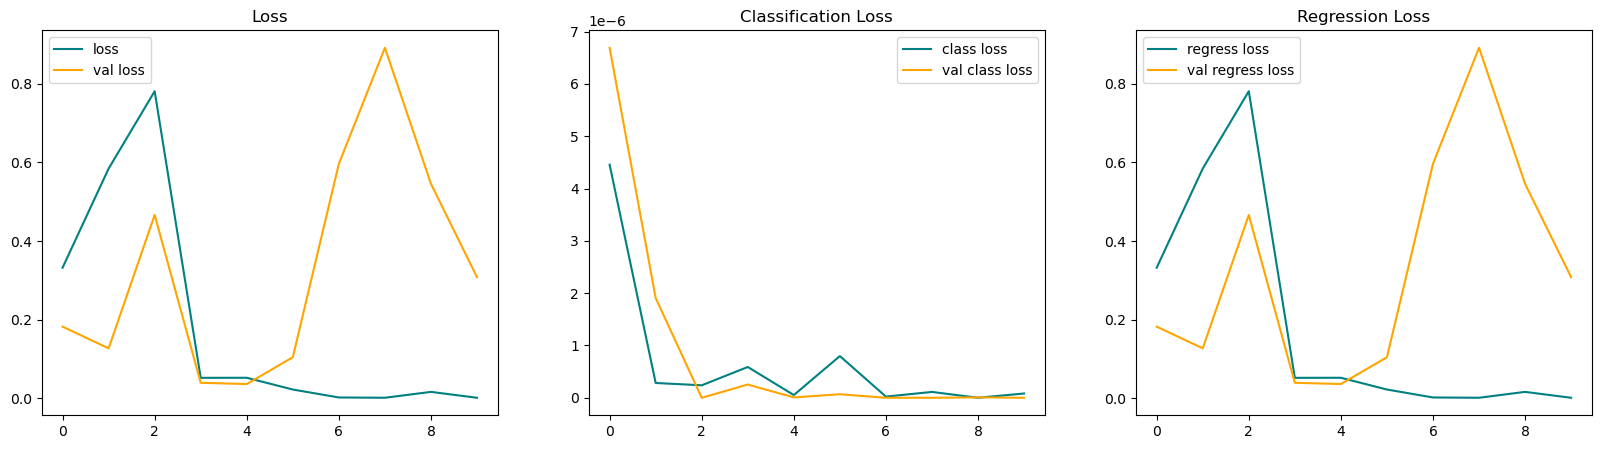

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 10. Make Predictions

### 10.1 Make Predictions 

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facedetector.predict(test_sample[0])

1/1 [==============================] - 0s 238ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


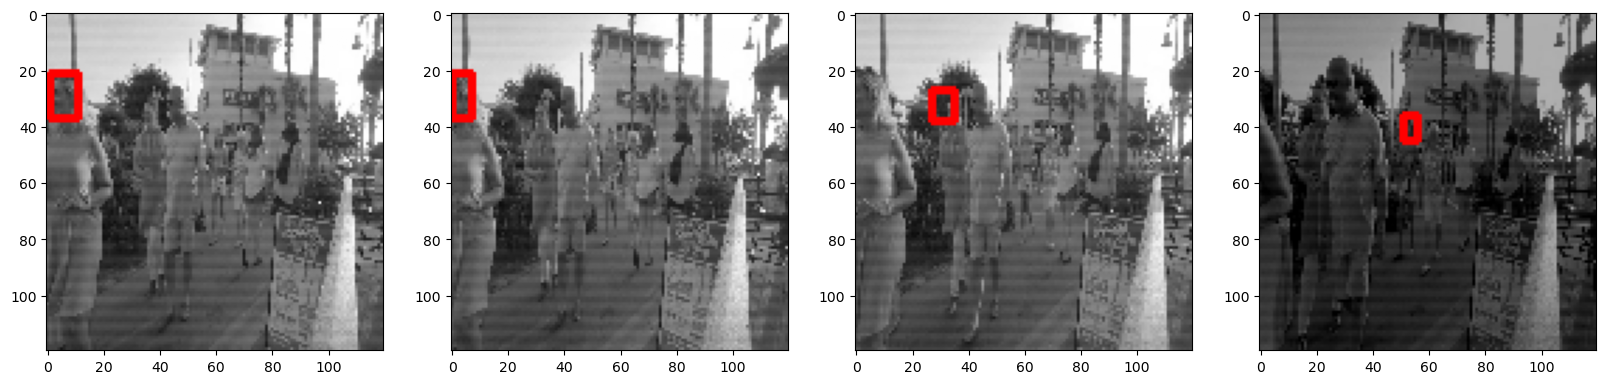

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(40,40))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [240,240]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [240,240]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 10.2 Save the Model

In [ ]:
from keras.models import load_model

In [ ]:
facedetector.save('facecctv.h5')

# 12 Testing

### 12.1 Loading Models

In [ ]:
facedetector = load_model('./models/facetracker.h5')
facecctv = load_model('facecctv.h5')

### 12.2 Testing face detection using webcam live

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facedetector.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [1280, 720]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [1280, 720]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 12.3 Testing using dataset static images

In [ ]:
image = cv2.imread('data\\footage\\0.jpg')
plt.imshow(image)

rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(rgb, (120, 120))

yhat = facedetector.predict(np.expand_dims(resized/255,0))
sample_coords = yhat[1][0]

if yhat[0] > 0.5: 
    # Controls the main rectangle
    cv2.rectangle(image, 
                    tuple(np.multiply(sample_coords[:2], [1280, 720]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [1280, 720]).astype(int)), 
                        (255,0,0), 2)
    # Controls the label rectangle
    cv2.rectangle(image, 
                    tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int), 
                                [0,-30])),
                    tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int),
                                [80,0])), 
                        (255,0,0), -1)
    
    # Controls the text rendered
    cv2.putText(image, 'face', tuple(np.add(np.multiply(sample_coords[:2], [1280, 720]).astype(int),
                                            [0,-5])),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

cv2.imshow('EyeTrack', image)

NameError: name 'cv2' is not defined